In [1]:
import os
import logging
from pathlib import Path
import datetime

from tqdm import tqdm
import numpy as np
import math
import pandas as pd
import random

import torch
from torch.utils.data import DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

import torch.nn as nn 
from torch.nn.utils import parameters_to_vector
import torch.optim as optim
from torchinfo import summary

from brevitas.export import export_onnx_qcdq

import torchmetrics

import cv2

import config
import dataset
import models
import loss
import metrics
import train_epoch
import val_epoch
import utils

In [2]:
#torch.cuda.empty_cache()

# Logger

In [3]:
log_path = config.LOGS_FOLDER

logger = logging.getLogger("GonLogger")
logger.propagate = False
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler(log_path + 'logfile.log')
formatter = logging.Formatter('%(message)s')
file_handler.setFormatter(formatter)

# add file handler to logger
logger.addHandler(file_handler)

logger.info('BED Classifier XS Tiny.\n' +  
            '\tOne Head.\n' +
            '\t255 Normalization.\n' +
            '\tWeighted for Precision.\n' +
            '\tModules.\n'+ 
            '\tLosses and Metrics Loggers.\n' +
            '\tBrevitas with All Layers defined in the Model, but Dropout and Flatten.\n' +
            '\t10 epochs.\n')

# View Dataset

### Transform

In [4]:
view_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(config.IMG_H, config.IMG_W, p=1),
        ToTensorV2(p=1),
    ]
)

In [5]:
VIEW_BATCH_SIZE = 32

view_dfire_ds = dataset.DFireDataset(
    img_h=config.IMG_H, 
    img_w=config.IMG_W, 
    img_dir=config.val_imgs, 
    label_dir=config.val_labels, 
    num_classes=config.N_CLASSES,
    ds_len=2*VIEW_BATCH_SIZE,
    transform=view_transform)

view_loader = DataLoader(dataset=view_dfire_ds,
                         batch_size=VIEW_BATCH_SIZE,
                         num_workers=1,
                         pin_memory=True,
                         shuffle=True,
                         drop_last=False)
print(f'Val dataset length: {len(view_dfire_ds)}')

DFire Removed wrong images: 0
DFire empty images: 31
DFire only smoke images: 17
DFire only fire images: 2
DFire smoke and fire images: 14
Val dataset length: 64


# Plot Dataset Pictures

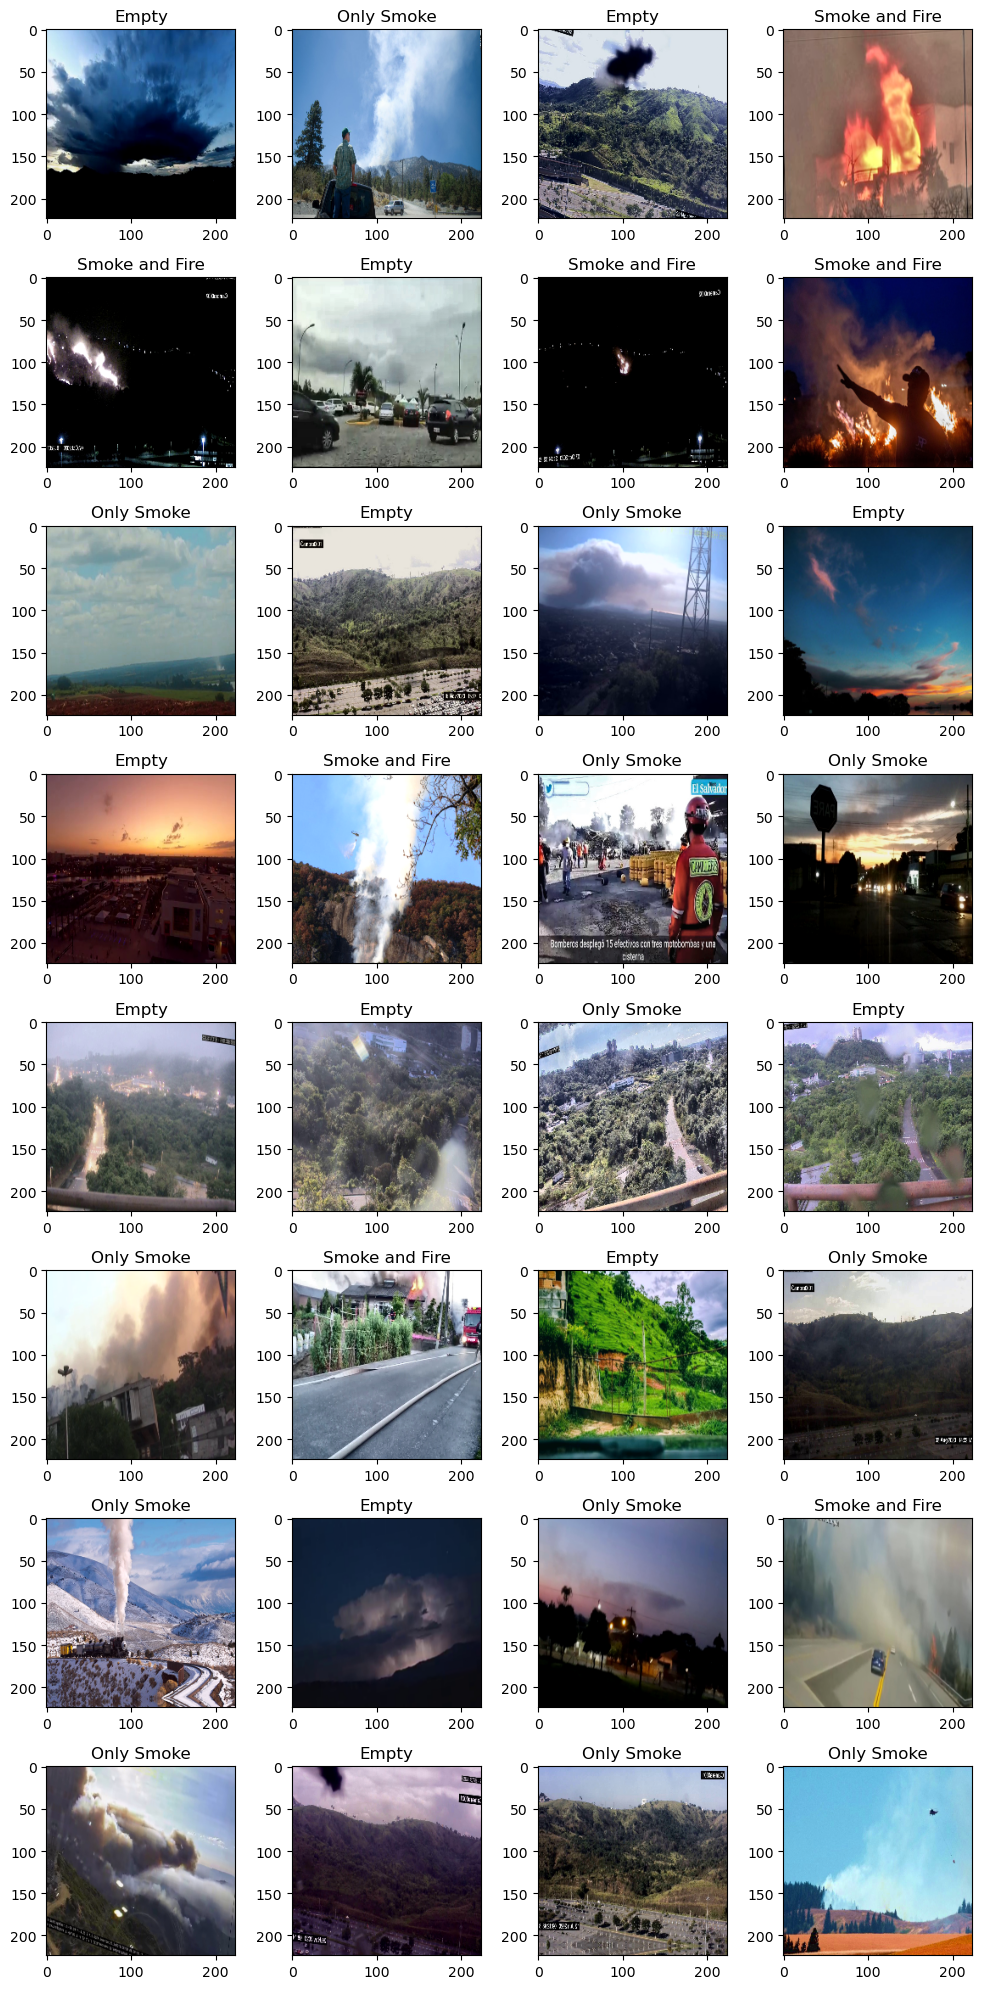

In [6]:
for i, (img, label) in enumerate(view_loader):

    plt.subplots(8,4, figsize=(10, 20))
    
    for idx in range(VIEW_BATCH_SIZE):
        plt.subplot(8, 4, idx+1)
        plt.imshow(img[idx].permute(1, 2, 0))
        title = ""
        if label[idx][0] == 1 and label[idx][1] == 1:
            title += "Smoke and Fire"
        elif label[idx][0] == 1 and label[idx][1] == 0:
            title += "Only Smoke"
        elif label[idx][0] == 0 and label[idx][1] == 1:
            title += "Only Fire"
        else:
            title += "Empty"
        plt.title(title)
        
        if (idx == 31):
            break
    plt.tight_layout()
    plt.show()
    break

# Dataset Setup

In [7]:
train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(config.IMG_H, config.IMG_W, p=1),
        #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1),
        ToTensorV2(p=1),
    ]
)

# TRAIN DATASET
print("\nTRAIN DFIRE dataset")
logger.info("\nTRAIN DFIRE dataset")
train_dataset = dataset.DFireDataset(
    img_h = config.IMG_H,
    img_w = config.IMG_W,
    img_dir = config.TRAIN_IMG_DIR,
    label_dir = config.TRAIN_LABEL_DIR,
    num_classes=config.N_CLASSES,
    ds_len = config.DS_LEN,
    transform=train_transform)

print(f'Train dataset len: {len(train_dataset)}')
logger.info(f'Train dataset len: {len(train_dataset)}')


# VALIDATION DATASET
val_transform = A.Compose([
    A.Resize(config.IMG_H, config.IMG_W, p=1),
    ToTensorV2(p=1),
    ]
)

print("\nTEST DFire dataset")
logger.info("\nTEST DFire dataset")
val_dataset = dataset.DFireDataset(
    img_h = config.IMG_H,
    img_w = config.IMG_W,
    img_dir = config.VAL_IMG_DIR,
    label_dir = config.VAL_LABEL_DIR,
    num_classes = config.N_CLASSES,
    ds_len = config.DS_LEN,
    transform=val_transform)

print(f'Test dataset len: {len(val_dataset)}')
logger.info(f'Test dataset len: {len(val_dataset)}')


# LOADERS
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=config.BATCH_SIZE,
                          num_workers=config.NUM_WORKERS,
                          pin_memory=config.PIN_MEMORY,
                          shuffle=True,
                          drop_last=True)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=config.BATCH_SIZE,
                        num_workers=config.NUM_WORKERS,
                        pin_memory=config.PIN_MEMORY,
                        shuffle=False,
                        drop_last=True)


TRAIN DFIRE dataset


Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


DFire Removed wrong images: 0
DFire empty images: 7833
DFire only smoke images: 4681
DFire only fire images: 944
DFire smoke and fire images: 3763
Train dataset len: 17221

TEST DFire dataset
DFire Removed wrong images: 0
DFire empty images: 2005
DFire only smoke images: 1186
DFire only fire images: 220
DFire smoke and fire images: 895
Test dataset len: 4306


# Models Setup

In [8]:
if config.MODEL == "BED":
    print("Using BED Classifier")
    logger.info("Using BED Classifier")
    fp32_model = models.BED_CLASSIFIER(num_classes=config.N_CLASSES).to(config.DEVICE)  
    quant_model = models.QUANTWeights_BED_CLASSIFIER(
        weight_bw = config.WEIGHTS_BIT_WIDTH,
        act_bw = config.ACTIVATIONS_BIT_WIDTH,
        bias_bw = config.BIAS_BIT_WIDTH,
        num_classes=config.N_CLASSES).to(config.DEVICE)  
else:
    print("Wrong Model")
    logger.info("Wrong Model")
    raise SystemExit("Wrong Model")

optimizer = optim.Adam(quant_model.parameters(), 
                       lr=config.LEARNING_RATE, 
                       weight_decay=config.WEIGHT_DECAY)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min',
                                                 factor=config.FACTOR, 
                                                 patience=config.PATIENCE, 
                                                 threshold=config.THRES, 
                                                 threshold_mode='abs',
                                                 min_lr=config.MIN_LR)

# MODEL PARAMETERS
n_trainable = sum(p.numel() for p in quant_model.parameters() if p.requires_grad)
print(f'\nTrainable parameters = {n_trainable}')
logger.info(f'\nTrainable parameters = {n_trainable}')

n_params = parameters_to_vector(quant_model.parameters()).numel()
print(f'Total parameters = {n_params}\n')
logger.info(f'Total parameters = {n_params}\n')

Using BED Classifier

Trainable parameters = 93279
Total parameters = 93279



### Check Model Shape

In [9]:
in_rand_np = np.random.rand(4, 3, config.IMG_H, config.IMG_W)
in_rand = torch.tensor(in_rand_np, dtype=torch.float32, device=config.DEVICE)
out_test = quant_model(in_rand)
print(f'Model shape is {out_test}')
print(f'BED Model Arquitecture\n{quant_model}')
logger.info(f'Model shape is {out_test}')
logger.info(f'BED Model Arquitecture\n{quant_model}')

/opt/conda/envs/pytorch_brevitas/lib/python3.10/site-packages/torch/_tensor.py:1362: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at /opt/conda/conda-bld/pytorch_1702400410390/work/c10/core/TensorImpl.h:1900.)
  return super().rename(names)


Model shape is tensor([[0.0132, 0.1516],
        [0.0132, 0.1516],
        [0.0132, 0.1516],
        [0.0132, 0.1516]], device='cuda:0', grad_fn=<AddmmBackward0>)
BED Model Arquitecture
QUANTWeights_BED_CLASSIFIER(
  (model): Sequential(
    (conv1): QuantConv2d(
      3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
      (input_quant): ActQuantProxyFromInjector(
        (_zero_hw_sentinel): StatelessBuffer()
      )
      (output_quant): ActQuantProxyFromInjector(
        (_zero_hw_sentinel): StatelessBuffer()
      )
      (weight_quant): WeightQuantProxyFromInjector(
        (_zero_hw_sentinel): StatelessBuffer()
        (tensor_quant): RescalingIntQuant(
          (int_quant): IntQuant(
            (float_to_int_impl): RoundSte()
            (tensor_clamp_impl): TensorClampSte()
            (delay_wrapper): DelayWrapper(
              (delay_impl): _NoDelay()
            )
          )
          (scaling_impl): StatsFromParameterScaling(
            (parameter_l

# Load Pretrained or Initialize Weights

In [10]:
fp32_optimizer = optim.Adam(
    fp32_model.parameters(), 
    lr=config.LEARNING_RATE, 
    weight_decay=config.WEIGHT_DECAY)

fp32_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    fp32_optimizer, 
    mode='min',
    factor=config.FACTOR, 
    patience=config.PATIENCE, 
    threshold=config.THRES, 
    threshold_mode='abs',
    min_lr=config.MIN_LR)

if config.LOAD_MODEL == False:
    if config.MODEL == "BED":
        fp32_model.__initialize_weights__()
        print("Initializing Weights")
        logger.info("Initializing Weights")
else:
    checkpoint = torch.load(config.LOAD_MODEL_FILE, map_location=config.DEVICE)
    fp32_model.load_state_dict(checkpoint['model_state_dict'])
    fp32_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    fp32_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch']
    print(f"Loading Model. Trained during {start_epoch} epochs")
    logger.info(f"Loading Model. Trained during {start_epoch} epochs")

Loading Model. Trained during 133 epochs


# Torchinfo: model summary

### Quant Model

In [11]:
print(summary(quant_model, input_size=(config.BATCH_SIZE, 3, config.IMG_H, config.IMG_W)))
logger.info(summary(quant_model, input_size=(config.BATCH_SIZE, 3, config.IMG_H, config.IMG_W)))

Layer (type:depth-idx)                                                 Output Shape              Param #
QUANTWeights_BED_CLASSIFIER                                            [64, 2]                   --
├─Sequential: 1-1                                                      [64, 2]                   --
│    └─QuantConv2d: 2-1                                                [64, 32, 224, 224]        --
│    │    └─ActQuantProxyFromInjector: 3-1                             [64, 3, 224, 224]         --
│    │    └─WeightQuantProxyFromInjector: 3-2                          [32, 3, 3, 3]             864
│    │    └─ActQuantProxyFromInjector: 3-3                             [64, 32, 224, 224]        --
│    └─BatchNorm2dToQuantScaleBias: 2-2                                [64, 32, 224, 224]        32
│    │    └─ActQuantProxyFromInjector: 3-4                             [64, 32, 224, 224]        --
│    │    └─WeightQuantProxyFromInjector: 3-5                          [32]                   

### FP32 Model

In [12]:
print(summary(fp32_model, input_size=(config.BATCH_SIZE, 3, config.IMG_H, config.IMG_W)))
logger.info(summary(fp32_model, input_size=(config.BATCH_SIZE, 3, config.IMG_H, config.IMG_W)))

Layer (type:depth-idx)                   Output Shape              Param #
BED_CLASSIFIER                           [64, 2]                   --
├─Sequential: 1-1                        [64, 2]                   --
│    └─Conv2d: 2-1                       [64, 32, 224, 224]        864
│    └─BatchNorm2d: 2-2                  [64, 32, 224, 224]        64
│    └─ReLU: 2-3                         [64, 32, 224, 224]        --
│    └─Dropout2d: 2-4                    [64, 32, 224, 224]        --
│    └─MaxPool2d: 2-5                    [64, 32, 112, 112]        --
│    └─Conv2d: 2-6                       [64, 16, 112, 112]        4,608
│    └─BatchNorm2d: 2-7                  [64, 16, 112, 112]        32
│    └─ReLU: 2-8                         [64, 16, 112, 112]        --
│    └─Dropout2d: 2-9                    [64, 16, 112, 112]        --
│    └─MaxPool2d: 2-10                   [64, 16, 56, 56]          --
│    └─Conv2d: 2-11                      [64, 16, 56, 56]          256
│    └─Bat

# Load Pretrained Weights from FP32 Model to Quant Model

In [13]:
print(f'Number of modules in the model: {len(fp32_model.model)}')

Number of modules in the model: 47


In [14]:
# # Try to load fp32 weights to quant_model
from brevitas import config as brevitas_config

brevitas_config.IGNORE_MISSING_KEYS = True

In [15]:
fp32_model.model[36].state_dict()

OrderedDict([('weight',
              tensor([4.9172e-42, 2.4924e-01, 3.5343e-01, 4.5216e-01, 6.9162e-01, 2.3842e-02,
                      9.0874e-01, 4.3876e-01, 6.4897e-01, 5.8757e-01, 6.0962e-01, 4.9298e-42,
                      6.2281e-01, 3.5747e-01, 5.7408e-01, 3.7566e-01, 5.5148e-01, 8.0725e-01,
                      7.5325e-01, 8.4036e-01, 4.1613e-01, 5.6551e-01, 6.9639e-01, 3.9864e-01,
                      5.0119e-01, 5.3412e-01, 4.7265e-01, 5.5369e-01, 7.0660e-01, 1.0106e+00,
                      6.4044e-01, 9.4437e-01], device='cuda:0')),
             ('bias',
              tensor([-4.9326e-42, -1.7319e-01, -6.2484e-02, -2.0624e-01, -4.5881e-01,
                      -2.6306e-02, -6.6161e-01, -1.6388e-01, -5.4088e-01, -2.6737e-01,
                      -1.1436e-01,  4.9382e-42, -3.5446e-01, -2.4344e-01, -3.8882e-01,
                      -2.8584e-01, -3.5217e-01, -5.4347e-01, -5.0295e-01, -3.1825e-01,
                      -2.7003e-01, -3.3046e-01, -7.4229e-03, -1.2841e-

In [16]:
# for i in range(47):
#     print(f'{i} layer')
#     if isinstance(fp32_model.model[i], nn.Conv2d):
#         quant_model.model[i].load_state_dict(fp32_model.model[i].state_dict())
#         print(f'*** Loading weights of Conv2d layer {fp32_model.model[i]}')
#     elif isinstance(fp32_model.model[i], nn.BatchNorm2d):
#         quant_model.model[i].load_state_dict(fp32_model.model[i].state_dict())
#         print(f'*** Load weights of BatchNorm layer {fp32_model.model[i]}')
#     elif isinstance(fp32_model.model[i], nn.Linear):
#         quant_model.model[i].load_state_dict(fp32_model.model[i].state_dict())
#         print(f'*** Loading weights of Linear layer {fp32_model.model[i]}')
#     else:
#         print(f'--- Ignore weights or params of layer {fp32_model.model[i]}')


for fp32_name, fp32_mod in fp32_model.named_modules():
    for quant_name, quant_mod in  quant_model.named_modules():
        if fp32_name == quant_name:
            print(f'fp32 model name: {fp32_name} - quant model name: {quant_name}')
            if isinstance(fp32_mod, nn.Conv2d):
                if fp32_name == quant_name:
                    quant_mod.load_state_dict(fp32_mod.state_dict())
                    print(f'\t****** Loading weights of Conv2d layer fp32 {fp32_name} into quant {quant_name}')
            elif isinstance(fp32_mod, nn.BatchNorm2d):
                if fp32_name == quant_name:
                    quant_mod.load_state_dict(fp32_mod.state_dict())
                    print(f'\t****** Loading weights of BN layer fp32 {fp32_name} into quant {quant_name}')
            elif isinstance(fp32_mod, nn.Linear):
                if fp32_name == quant_name:
                    quant_mod.load_state_dict(fp32_mod.state_dict())
                    print(f'\t****** Loading weights of Linear layer fp32 {fp32_name} into quant {quant_name}')
            else:
                print(f'\t______ Ignore weights or params of layer fp32 {fp32_name} and quant {quant_name}')

fp32 model name:  - quant model name: 
	______ Ignore weights or params of layer fp32  and quant 
fp32 model name: model - quant model name: model
	______ Ignore weights or params of layer fp32 model and quant model
fp32 model name: model.conv1 - quant model name: model.conv1
	****** Loading weights of Conv2d layer fp32 model.conv1 into quant model.conv1
fp32 model name: model.bn1 - quant model name: model.bn1
	****** Loading weights of BN layer fp32 model.bn1 into quant model.bn1
fp32 model name: model.relu1 - quant model name: model.relu1
	______ Ignore weights or params of layer fp32 model.relu1 and quant model.relu1
fp32 model name: model.dropout1 - quant model name: model.dropout1
	______ Ignore weights or params of layer fp32 model.dropout1 and quant model.dropout1
fp32 model name: model.maxpool2 - quant model name: model.maxpool2
	______ Ignore weights or params of layer fp32 model.maxpool2 and quant model.maxpool2
fp32 model name: model.conv2 - quant model name: model.conv2
	**

# Loss Function

In [17]:
if config.LOSS_FN == "BCE":
    print(f'Loss Function: BCE')
    logger.info(f'\nLoss Function: BCE')
    print(f'Smoke Precision Weight: {config.SMOKE_PRECISION_WEIGHT}')
    logger.info(f'Smoke Precision Weight: {config.SMOKE_PRECISION_WEIGHT}')
    loss_fn = loss.BCE_LOSS(device=config.DEVICE, smoke_precision_weight=config.SMOKE_PRECISION_WEIGHT)
else:
    print("Wrong loss function")
    logger.info("Wrong loss function")
    raise SystemExit("Wrong loss function")

Loss Function: BCE
Smoke Precision Weight: 0.8


# Print and Log Config Values

In [18]:
''' ============================
    Print Config Values
============================ '''
print(f'\nDevice: {config.DEVICE}')
print(f'Learning Rate: {config.LEARNING_RATE}')
print(f'Weight Decay: {config.WEIGHT_DECAY}')
print(f'Batch Size: {config.BATCH_SIZE}')
print(f'IMG DIMS: ({config.IMG_H}, {config.IMG_W})')

logger.info(f'\nDevice: {config.DEVICE}')
logger.info(f'Learning Rate: {config.LEARNING_RATE}')
logger.info(f'Weight Decay: {config.WEIGHT_DECAY}')
logger.info(f'Scheduler factor: {config.FACTOR}')
logger.info(f'Scheduler patience: {config.PATIENCE}')
logger.info(f'Scheduler threshold: {config.THRES}')
logger.info(f'Scheduler min learning rate: {config.MIN_LR}')
logger.info(f'Batch Size: {config.BATCH_SIZE}')
logger.info(f'W: {config.IMG_W}\nH: {config.IMG_H}')
logger.info(f'Batch Size: {config.BATCH_SIZE}')
logger.info(f'W: {config.IMG_W}\nH: {config.IMG_H}')


Device: cuda
Learning Rate: 1e-05
Weight Decay: 1e-05
Batch Size: 64
IMG DIMS: (224, 224)


# Loss and Metrics Loggers and Plotters

In [19]:
train_losses_logger = utils.LogLosses()
train_metrics_logger = utils.LogMetrics()
lr_logger = utils.LogLR(log_path=config.PLOTS_FOLDER)

val_losses_logger = utils.LogLosses()
val_metrics_logger = utils.LogMetrics()

loss_plotter = utils.PlotMetrics(log_path=config.PLOTS_FOLDER, model_name=config.MODEL, loss_or_metric='Loss')
metrics_plotter = utils.PlotMetrics(log_path=config.PLOTS_FOLDER, model_name=config.MODEL, loss_or_metric='Metric')

# Main Function

In [20]:
def train_loop(model, start_epoch=0):

    ''' ==============================================================
                                TRAINING LOOP
    ============================================================== '''
    start = datetime.datetime.now()
    start_time = start.strftime("%H:%M:%S")
    print(f'\n***Start Training: {start_time}\n')
    logger.info(f'\n***Start Training: {start_time}\n')
    
    # Start with infinite validation loss
    best_valid_loss = np.inf
    best_smoke_precision = 0. #torch.tensor([0.])
    smoke_f1_min_save = 0.9 #torch.tensor([0.9])

    #start_epoch = 0
    epochs_plot = []
        
    for epoch in range(start_epoch, config.EPOCHS):

        print(f'\n=== EPOCH {epoch}/{config.EPOCHS-1} ===')
        logger.info(f'\n=== EPOCH {epoch}/{config.EPOCHS-1} ===')
        
        #====================== TRAINING ========================#
        current_lr = train_epoch.get_lr(optimizer=optimizer)
        logger.info(f'Learning Rate = {current_lr}\n')
        lr_logger.log_lr(current_lr)
                
        train_losses, train_metrics = train_epoch.train_fn(
            loader=train_loader, 
            model=model, 
            optimizer=optimizer, 
            loss_fn=loss_fn,
            device=config.DEVICE)
        
        train_losses_logger.update_metrics(train_losses)
        train_metrics_logger.update_metrics(train_metrics)
                
        logger.info(utils.print_metrics_to_logger("TRAIN Stats", train_losses, train_metrics))
        
        #===================== VALIDATING =======================#
        with torch.no_grad():
            val_losses, val_metrics = val_epoch.eval_fn(
                loader=val_loader, 
                model=model,                         
                loss_fn=loss_fn,
                device=config.DEVICE)
            
            scheduler.step(val_losses['Total'])
            
            val_losses_logger.update_metrics(val_losses)
            val_metrics_logger.update_metrics(val_metrics)

            logger.info(utils.print_metrics_to_logger("VAL Stats", val_losses, val_metrics))
            
        epochs_plot.append(epoch)

        loss_plotter.plot_all_metrics(
            train_losses_logger.get_metrics(),
            val_losses_logger.get_metrics(),
            epochs_plot)

        metrics_plotter.plot_all_metrics(
            train_metrics_logger.get_metrics(),
            val_metrics_logger.get_metrics(),
            epochs_plot)

        lr_logger.plot_lr(epochs_plot)
        #======================= SAVING =========================#
        if ( (epoch+1) % 5 ) == 0:
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__5epoch.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name) 
            
        if best_valid_loss > val_losses['Total']:
            best_valid_loss = val_losses['Total']
            print(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            logger.info(f"Saving model with new best validation loss: {best_valid_loss:.3f}")
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__' + 'best_loss'  + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name)  

        # Save model if precision increases and F1 > 0.9
        if ( best_smoke_precision < val_metrics['Precision'][0] ) and ( val_metrics['F1'][0] > smoke_f1_min_save ) :
            best_smoke_precision = val_metrics['Precision'][0]
            print(f"\nSaving model with new best smoke precision: {best_smoke_precision:.3f}")
            logger.info(f"Saving model with new best smoke precision: {best_smoke_precision:.3f}")
            save_precision_name = f'best_smoke__precision={np.round(best_smoke_precision, decimals=4)}__epoch={epoch}'
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__' + save_precision_name + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name)  
            
        # Save model if precision > 0.9 and recall > 0.9
        if ( val_metrics['Precision'][0] > 0.9 ) and ( val_metrics['Recall'][0] > 0.9 ) :
            print("\nSaving model with precision > 0.9 and recall > 0.9")
            logger.info("Saving model with precision > 0.9 and recall > 0.9")
            save_pre_name = f'smoke__precision={np.round(val_metrics["Precision"][0], decimals=4)}__' 
            save_rec_name = f'recall={np.round(val_metrics["Recall"][0], decimals=4)}__'
            save_pre_rec_name = save_pre_name + save_rec_name + f'epoch={epoch}'
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__' + save_pre_rec_name + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name)  
        
    logger.info('Saving last model')   
    torch.save(model.state_dict(), config.WEIGHTS_FOLDER + 'last_' + config.MODEL + '_classifier.pt') 
    
    #======================= FINISH =========================#
    end = datetime.datetime.now()
    end_time = end.strftime("%H:%M:%S")
    print(f'\n***Script finished: {end_time}\n')  
    print(f'Time elapsed: {end-start}')
    logger.info(f'\n***Script finished: {end_time}\n')  
    logger.info(f'Time elapsed: {end-start}')
    
    return model

# Main execute

In [21]:
if __name__ == "__main__":
    
    print("Starting script\n")
    logger.info("Starting script\n")
    
    qnn_model = train_loop(model=quant_model)

Starting script


***Start Training: 16:39:20


=== EPOCH 0/19 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [03:30<00:00,  1.28it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.312      |19.173      |8.140       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 17.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.895      |14.728      |7.168       
SMOKE -> Precision: 0.903 - Recall: 0.878 - Accuracy: 0.896 - F1: 0.891
FIRE -> Precision: 0.928 - Recall: 0.920 - Accuracy: 0.961 - F1: 0.924

Saving model with new best validation loss: 21.895

=== EPOCH 1/19 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:49<00:00,  5.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.715      |17.252      |7.463       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 16.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.149      |14.197      |6.952       
SMOKE -> Precision: 0.910 - Recall: 0.880 - Accuracy: 0.900 - F1: 0.895
FIRE -> Precision: 0.937 - Recall: 0.920 - Accuracy: 0.963 - F1: 0.928

Saving model with new best validation loss: 21.149

=== EPOCH 2/19 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  8.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.841      |16.676      |7.164       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 16.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.184      |14.322      |6.862       
SMOKE -> Precision: 0.902 - Recall: 0.883 - Accuracy: 0.898 - F1: 0.892
FIRE -> Precision: 0.935 - Recall: 0.930 - Accuracy: 0.965 - F1: 0.932

=== EPOCH 3/19 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.884      |16.601      |7.283       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 16.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.497      |13.714      |6.783       
SMOKE -> Precision: 0.913 - Recall: 0.892 - Accuracy: 0.907 - F1: 0.902
FIRE -> Precision: 0.929 - Recall: 0.933 - Accuracy: 0.964 - F1: 0.931

Saving model with new best validation loss: 20.497

Saving model with new best smoke precision: 0.913

=== EPOCH 4/19 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.309      |16.059      |7.250       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 16.79it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.700      |13.795      |6.905       
SMOKE -> Precision: 0.914 - Recall: 0.882 - Accuracy: 0.903 - F1: 0.898
FIRE -> Precision: 0.944 - Recall: 0.913 - Accuracy: 0.963 - F1: 0.928

=== EPOCH 5/19 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.210      |15.970      |7.240       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 16.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.602      |13.855      |6.747       
SMOKE -> Precision: 0.900 - Recall: 0.897 - Accuracy: 0.903 - F1: 0.899
FIRE -> Precision: 0.932 - Recall: 0.931 - Accuracy: 0.965 - F1: 0.931

=== EPOCH 6/19 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.068      |16.156      |6.912       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 16.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.613      |13.810      |6.803       
SMOKE -> Precision: 0.911 - Recall: 0.890 - Accuracy: 0.905 - F1: 0.900
FIRE -> Precision: 0.933 - Recall: 0.930 - Accuracy: 0.965 - F1: 0.931

=== EPOCH 7/19 ===
Learning Rate = 8.000000000000001e-06



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  8.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.110      |15.965      |7.145       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 16.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.558      |13.705      |6.853       
SMOKE -> Precision: 0.903 - Recall: 0.902 - Accuracy: 0.906 - F1: 0.902
FIRE -> Precision: 0.932 - Recall: 0.929 - Accuracy: 0.964 - F1: 0.931

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 8/19 ===
Learning Rate = 8.000000000000001e-06



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.917      |15.840      |7.077       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 16.85it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.644      |13.733      |6.911       
SMOKE -> Precision: 0.909 - Recall: 0.893 - Accuracy: 0.906 - F1: 0.901
FIRE -> Precision: 0.921 - Recall: 0.933 - Accuracy: 0.962 - F1: 0.927

=== EPOCH 9/19 ===
Learning Rate = 8.000000000000001e-06



Training: 100%|███████████████████████████████| 269/269 [00:30<00:00,  8.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.431      |15.497      |6.935       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 16.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.790      |13.899      |6.892       
SMOKE -> Precision: 0.927 - Recall: 0.870 - Accuracy: 0.904 - F1: 0.897
FIRE -> Precision: 0.944 - Recall: 0.915 - Accuracy: 0.964 - F1: 0.930

=== EPOCH 10/19 ===
Learning Rate = 6.400000000000001e-06



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.108      |15.985      |7.123       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 16.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.513      |13.819      |6.694       
SMOKE -> Precision: 0.910 - Recall: 0.882 - Accuracy: 0.901 - F1: 0.895
FIRE -> Precision: 0.939 - Recall: 0.928 - Accuracy: 0.966 - F1: 0.933

=== EPOCH 11/19 ===
Learning Rate = 6.400000000000001e-06



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.856      |15.701      |7.155       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 16.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.470      |13.754      |6.716       
SMOKE -> Precision: 0.897 - Recall: 0.910 - Accuracy: 0.907 - F1: 0.904
FIRE -> Precision: 0.935 - Recall: 0.932 - Accuracy: 0.965 - F1: 0.933

Saving model with new best validation loss: 20.470

=== EPOCH 12/19 ===
Learning Rate = 6.400000000000001e-06



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.878      |15.736      |7.141       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 16.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.613      |13.843      |6.770       
SMOKE -> Precision: 0.918 - Recall: 0.880 - Accuracy: 0.904 - F1: 0.898
FIRE -> Precision: 0.942 - Recall: 0.922 - Accuracy: 0.965 - F1: 0.932

=== EPOCH 13/19 ===
Learning Rate = 6.400000000000001e-06



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  8.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.753      |15.679      |7.074       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 16.27it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.363      |13.557      |6.806       
SMOKE -> Precision: 0.909 - Recall: 0.905 - Accuracy: 0.910 - F1: 0.907
FIRE -> Precision: 0.938 - Recall: 0.931 - Accuracy: 0.966 - F1: 0.934

Saving model with new best validation loss: 20.363

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 14/19 ===
Learning Rate = 6.400000000000001e-06



Training: 100%|███████████████████████████████| 269/269 [00:30<00:00,  8.85it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.869      |15.820      |7.050       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 16.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.319      |13.492      |6.827       
SMOKE -> Precision: 0.911 - Recall: 0.898 - Accuracy: 0.909 - F1: 0.904
FIRE -> Precision: 0.933 - Recall: 0.931 - Accuracy: 0.965 - F1: 0.932

Saving model with new best validation loss: 20.319

=== EPOCH 15/19 ===
Learning Rate = 6.400000000000001e-06



Training: 100%|███████████████████████████████| 269/269 [00:30<00:00,  8.89it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.723      |15.780      |6.943       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 16.44it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.935      |14.151      |6.784       
SMOKE -> Precision: 0.917 - Recall: 0.873 - Accuracy: 0.901 - F1: 0.894
FIRE -> Precision: 0.938 - Recall: 0.928 - Accuracy: 0.965 - F1: 0.933

=== EPOCH 16/19 ===
Learning Rate = 6.400000000000001e-06



Training: 100%|███████████████████████████████| 269/269 [00:30<00:00,  8.92it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.857      |15.769      |7.088       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 16.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.766      |13.913      |6.853       
SMOKE -> Precision: 0.920 - Recall: 0.881 - Accuracy: 0.906 - F1: 0.900
FIRE -> Precision: 0.922 - Recall: 0.939 - Accuracy: 0.964 - F1: 0.930

Saving model with new best smoke precision: 0.920

=== EPOCH 17/19 ===
Learning Rate = 6.400000000000001e-06



Training: 100%|███████████████████████████████| 269/269 [00:30<00:00,  8.89it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.119      |15.861      |7.257       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 16.26it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.348      |13.489      |6.859       
SMOKE -> Precision: 0.906 - Recall: 0.904 - Accuracy: 0.909 - F1: 0.905
FIRE -> Precision: 0.934 - Recall: 0.923 - Accuracy: 0.963 - F1: 0.928

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 18/19 ===
Learning Rate = 5.120000000000002e-06



Training: 100%|███████████████████████████████| 269/269 [00:30<00:00,  8.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.859      |15.762      |7.098       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 16.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.778      |13.929      |6.849       
SMOKE -> Precision: 0.925 - Recall: 0.872 - Accuracy: 0.904 - F1: 0.897
FIRE -> Precision: 0.937 - Recall: 0.918 - Accuracy: 0.963 - F1: 0.928

=== EPOCH 19/19 ===
Learning Rate = 5.120000000000002e-06



Training: 100%|███████████████████████████████| 269/269 [00:30<00:00,  8.87it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.631      |15.794      |6.836       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 16.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.672      |13.731      |6.940       
SMOKE -> Precision: 0.915 - Recall: 0.890 - Accuracy: 0.908 - F1: 0.903
FIRE -> Precision: 0.945 - Recall: 0.914 - Accuracy: 0.964 - F1: 0.929

***Script finished: 16:54:17

Time elapsed: 0:14:57.040461


# Export to ONNX

In [22]:
export_onnx_qcdq(
    qnn_model, 
    torch.randn(1, 3, config.IMG_H, config.IMG_W).to(config.DEVICE), 
    export_path=config.RUN_FOLDER+'pretrained_epochs.onnx')

/opt/conda/envs/pytorch_brevitas/lib/python3.10/site-packages/brevitas/export/onnx/standard/manager.py:26: UserWarning: ONNX opset version set to 13, override with opset_version=
  warnings.warn(f"ONNX opset version set to {DEFAULT_OPSET}, override with {ka}=")


# Inference example

In [23]:
quant_model.eval()
ex_in = torch.randn((1, 3, 224, 224)).to(config.DEVICE)
ex_out = quant_model(ex_in)
ex_out

tensor([[-7.4466, -4.0884]], device='cuda:0', grad_fn=<AddmmBackward0>)